NLP Project

In [254]:
import sqlite3
import pandas as pd
import numpy as np

import pickle
from collections import namedtuple
from collections import defaultdict
from copy import deepcopy
import random

from textblob import TextBlob
import enchant
import re
import nltk
from nltk.corpus import words
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

# Connect to database

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204135 entries, 0 to 204134
Data columns (total 1 columns):
0    191532 non-null object
dtypes: object(1)
memory usage: 1.6+ MB


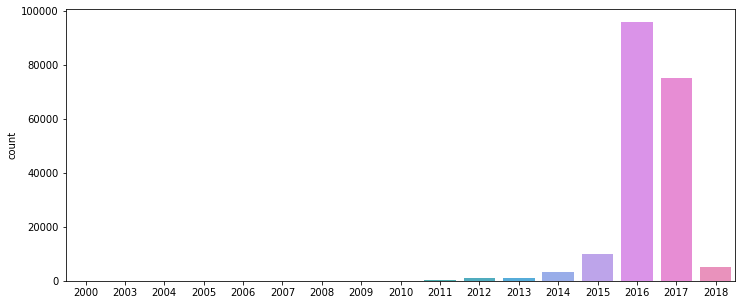

In [255]:
conn = sqlite3.connect("all-the-news.db")
cur = conn.cursor()
coords = cur.execute("""
SELECT year
FROM longform;
""").fetchall()

dd = pd.DataFrame(coords)
# df.columns = ["id", "title", "author", "date", "content", "year", \
#               "month", "publication", "category", "digital", "section", "url"]
dd.info()

plt.figure(figsize=(12, 5))
g = sns.countplot(sorted([ x for x in list(dd[0]) if type(x)==int]))

In [256]:
# load database to dataframe

conn = sqlite3.connect("all-the-news.db")
cur = conn.cursor()
coords = cur.execute("""
SELECT *
FROM longform
WHERE content LIKE '% LGBT % LGBT %'
--WHERE content LIKE '%LGBT right%'
--WHERE content LIKE '% math %'
;""").fetchall()

df = pd.DataFrame(coords)
df.columns = ["id", "title", "author", "date", "content", "year", \
              "month", "publication", "category", "digital", "section", "url"]
df.index = df.id
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1131 entries, 64 to 250117
Data columns (total 12 columns):
id             1131 non-null int64
title          1131 non-null object
author         1073 non-null object
date           1128 non-null object
content        1131 non-null object
year           1128 non-null float64
month          1128 non-null float64
publication    1131 non-null object
category       1090 non-null object
digital        1124 non-null float64
section        794 non-null object
url            847 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 114.9+ KB


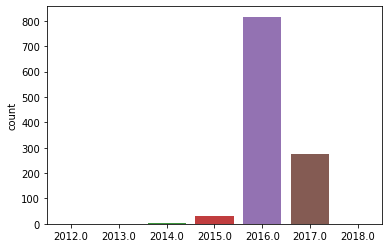

In [4]:
g = sns.countplot(sorted([ x for x in list(df.year) if str(x) != "nan" ]))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

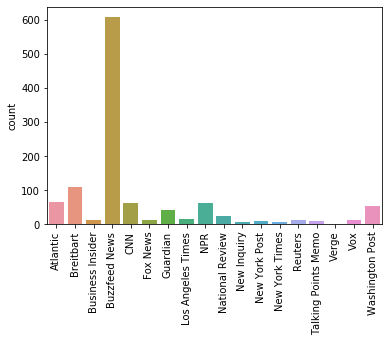

In [162]:
g = sns.countplot( sorted([ x for x in list(df.publication) if str(x) != "nan" ]))
plt.xticks(rotation=90)

## Data overview

In [257]:
corpus = list(df.content)
doc_len = [ len(x.split()) for x in corpus ]

print("LGBT right news documents number: {}\nword count:\ntotal\t{}\nmean\t{:0.2f}\nmin\t{}\nmax\t{}\n"\
      .format(len(corpus), np.sum(doc_len), np.mean(doc_len), np.min(doc_len), np.max(doc_len)))

# distinct categorical data
for i in ["year", "month", "publication", "category", "digital"]:
    print("<{}>\t".format(i), df[i].unique(), "\n")

LGBT right news documents number: 1131
word count:
total	1831283
mean	1619.17
min	159
max	20330

<year>	 [2015. 2017. 2014. 2016.   nan 2013. 2012. 2018.] 

<month>	 [ 8.  9.  1.  2.  4.  6.  3.  7. 11.  5. 10. 12. nan] 

<publication>	 ['Verge' 'Los Angeles Times' 'Breitbart' 'CNN' 'Business Insider'
 'Atlantic' 'Fox News' 'Talking Points Memo' 'Buzzfeed News'
 'National Review' 'New York Post' 'Guardian' 'NPR' 'Reuters' 'Vox'
 'Washington Post' 'New Inquiry' 'New York Times'] 

<category>	 ['Longform' 'Reports' 'newspaper' 'general' 'broadcast' 'business' None
 'radio' 'wire'] 

<digital>	 [ 1.  0.  2.  4.  3. nan] 



# Data cleaning

## Clean non-Latin alphabets, numbers, symbols and non-English words

In [258]:
# clean non-Latin alphabets

for i, doct in enumerate(corpus):
    corpus[i] = re.sub(r"[^a-zA-Z]"," ", corpus[i])

# clean non-English words
# length of letters must be more than 2
# use second elif to white-list some key words that get filtered by dictionary
# use the next white list section to find white-list words and add to this function

white_list = ['LGBT',
 'transgender',
 'Obama',
 'Guti',
 'BuzzFeed',
 'Sorena',
 'Kamikawa',
 'waria',
 'Wilders',
 'Facebook',
 'Laroze',
 'Usami',
 'McCrory',
 'https',
 'pic',
 'online',
 'Timmons',
 'Shinta',
 'Molkara',
 'Okada',
 'Hase',
 'Setagaya',
 'Troupis',
 'Wolfson',
 'Jennicet',
 'internet',
 'Barack',
 'Gorsuch',
 'Mateen',
 'Familia',
 'apps',
 'Islamist',
 'Philippot',
 'Wahid',
 'Yogyakarta',
 'Nicoll',
 'Terada',
 'LGBTQ',
 'Transgender',
 'Breitbart',
 'UK',
 'chemsex',
 'DC',
 'Mohsen',
 'Palma',
 'Siggi',
 'Yiannopoulos',
 'DeVos',
 'Ivanka',
 'Bachelet',
 'YouTube',
 'Alarc',
 'shouldn',
 'Kellermeyer',
 'cisgender',
 'Holtzmann',
 'Tegan',
 'Deitch',
 'Rubio',
 'Netflix',
 'Papua',
 'ad',
 'heteronormativity',
 'Manus',
 'LGBTI',
 'Obamacare']

white_list = white_list + [x.lower() for x in white_list]

d = enchant.Dict("en_US")
discard_word = defaultdict(int)

stemmer = LancasterStemmer()

for i, doc in enumerate(corpus):
    temp_str = ""
    for word in doc.split():
        if (d.check(word)) & (len(word)>=3) :
            temp_str += word + " "
        elif (d.check(word.lower())) & (len(word)>=3) :
            temp_str += word + " "
        elif word in white_list:
            temp_str += word + " "
        else:
            discard_word[word] += 1
    corpus[i] = temp_str

In [7]:
# key word test

# c=0
# for i in corpus:
#     state = False
#     for j in i.split():
#         if (j=="LGBT") :
#             state=True
#     if state == False:
#         c+=1
#         print(c, "wrong result")

## White-list discarded high frequency words (iterative process together with the cell above)

In [8]:
white_list = []
for i, j, in zip(discard_word.keys(), discard_word.values()):
    if j >= 200:
        white_list.append([i, j])
        
white_list = [x[0] for x in sorted(white_list, key=lambda x: x[1], reverse= True)]

# check white_list and add back to last subsection

# white_list

# post-cleaning stats

# doc_len = [ len(x.split()) for x in corpus ]
# print("LGBT right news documents number: {}\nword count:\ntotal\t{}\nmean\t{:0.2f}\nmin\t{}\nmax\t{}"\
#       .format(len(corpus), np.sum(doc_len), np.mean(doc_len), np.min(doc_len), np.max(doc_len)))

## Keep unique documents

In [259]:
# count vectorizer prepares the cosine distance comparism between documents

cv = CountVectorizer(stop_words = "english")
X = cv.fit_transform(corpus).toarray()
dt = pd.DataFrame(X, columns = cv.get_feature_names())
dt.head()

,aaron,aback,abandon,abandoned,abandoning,abandonment,abandons,abbey,abbot,abbott,...,zombies,zone,zones,zoning,zoo,zookeepers,zooms,zoos,zoroastrians,zulema
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0


In [260]:
# remove documents that are cosine similar, output unique doc_index
# waiting time is too long, print plus sign to show progress

cos_dist = cosine_similarity(dt)

doc_index = list(deepcopy(dt.index))
check_index = 0

while check_index < len(doc_index)-1:
    remove_index = []  
    for i in range(check_index + 1, len(doc_index)):
        cos_val = cos_dist[doc_index[check_index]][doc_index[i]]
        if cos_val > 0.9:
            remove_index.append(i)
    for j in remove_index[::-1]:
        doc_index.pop(j)
    check_index += 1
    print("+", end="")

# work out the document id index for doc-topic matrix
doc_unique_id = []
for i in doc_index:
    doc_unique_id.append(df.index[i])
    
# outputs doc_index list that contains unique documents

temp_list = []
for i in doc_index:
    temp_list.append(corpus[i])
corpus = temp_list

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [11]:
# pickle.dump( doc_index, open( "query2lgbt1573.pkl", "wb" ) )
# doc_index = pickle.load( open( "query2lgbt1573.pkl", "rb" ) )

In [12]:
# check remaining document's similarity

# c = 0
# for i in cosine_similarity(dt.iloc[doc_index]):
#     for j in i:
#         if j > 0.99:
#             c+=1
# print(c- len(cosine_similarity(dt.iloc[doc_index])))

# Topic modeling

## TFIDF count vectorizers

In [157]:
# cv = CountVectorizer(stop_words = "english", ngram_range=(2, 2), max_df=1.0, min_df=1)
# X = cv.fit_transform(corpus).toarray()
# dt = pd.DataFrame(X, columns = cv.get_feature_names())
# dt.index = doc_unique_id
# dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 64 to 250117
Columns: 22645 entries, aaron to zulema
dtypes: float64(22645)
memory usage: 113.3 MB


In [261]:
cv_tfidf = TfidfVectorizer(stop_words = "english", ngram_range=(1, 2), max_df=1.0, min_df=1)
X_tfidf = cv_tfidf.fit_transform(corpus).toarray()
dt = pd.DataFrame(X_tfidf, columns=cv_tfidf.get_feature_names())
dt.index = doc_unique_id
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 64 to 250117
Columns: 306171 entries, aaron to zulema told
dtypes: float64(306171)
memory usage: 1.5 GB


## NMF

In [262]:
# specify the size of word-topic matrix

topic_num = 20
word_num = 20
doc_num = 20

model = NMF(n_components=topic_num, init='random', random_state=42)
df1 = pd.DataFrame(model.fit_transform(dt))
df1.index = dt.index

df2 = pd.DataFrame(model.components_)
df2.columns = dt.columns
df2 = df2.T

## Topic modeling

In [263]:
frame = []
for i in range(0, topic_num):
    s = df2[i].sort_values(ascending=False)[:word_num]
    frame.append(pd.DataFrame([ (i, round(j, 2)) for i, j in zip(s.index, s.values) ]).apply(tuple, axis=1) )

df3 = pd.concat(frame, axis=1)
df3.columns = ["topic_{}_score".format(i) for i in range(0, topic_num)]
df3.index = ["word_{}".format(i) for i in range(0, word_num)]

# top words relavent the topic, tuples are (word, topic relavent score)
df3

,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,topic_6_score,topic_7_score,topic_8_score,topic_9_score,topic_10_score,topic_11_score,topic_12_score,topic_13_score,topic_14_score,topic_15_score,topic_16_score,topic_17_score,topic_18_score,topic_19_score
word_0,"(marriage, 2.83)","(charlotte, 1.43)","(religious, 4.38)","(archive, 3.36)","(stonewall, 6.88)","(getty, 1.9)","(carolina, 4.8)","(trump, 8.12)","(trans, 5.48)","(orlando, 4.22)","(ncaa, 5.59)","(jenner, 6.08)","(sessions, 5.49)","(queer, 2.04)","(students, 2.02)","(reuters, 1.52)","(clinton, 5.4)","(indonesia, 1.86)","(pence, 5.12)","(church, 3.03)"
word_1,"(sex, 1.96)","(cooper, 1.08)","(religious freedom, 2.0)","(archive team, 2.65)","(inn, 3.34)","(california, 1.86)","(north carolina, 4.77)","(president, 1.73)","(people, 2.47)","(mateen, 3.66)","(north carolina, 2.0)","(republican, 1.5)","(civil, 1.14)","(gay, 1.81)","(school, 1.32)","(news, 1.48)","(sanders, 2.15)","(chechnya, 1.42)","(trump, 1.56)","(pope, 1.27)"
word_2,"(couples, 1.73)","(repeal, 1.03)","(freedom, 1.93)","(team, 1.98)","(stonewall inn, 3.3)","(credits, 1.77)","(north, 4.6)","(obama, 1.72)","(transgender, 2.36)","(june, 2.34)","(carolina, 1.99)","(jenner said, 1.34)","(civil rights, 1.11)","(like, 1.49)","(transgender, 1.29)","(thomson, 0.82)","(hillary, 1.33)","(gay, 1.32)","(indiana, 1.52)","(mormon, 0.92)"
word_3,"(court, 1.53)","(state, 0.73)","(discrimination, 1.14)","(projects, 1.74)","(monument, 2.99)","(heat wave, 1.74)","(law, 3.39)","(said, 1.41)","(gender, 1.97)","(shooting, 1.9)","(north, 1.88)","(sawyer, 1.31)","(rights, 1.1)","(film, 1.46)","(schools, 1.23)","(thomson reuters, 0.82)","(says, 1.08)","(said, 1.17)","(mike pence, 0.63)","(francis, 0.83)"
word_4,"(sex marriage, 1.34)","(ordinance, 0.67)","(state, 1.14)","(collections, 1.71)","(new york, 2.8)","(southern california, 1.55)","(mccrory, 2.87)","(donald, 1.38)","(women, 1.61)","(pulse, 1.8)","(events, 1.52)","(republican party, 0.95)","(attorney, 1.03)","(black, 1.46)","(administration, 1.15)","(business news, 0.81)","(hillary clinton, 0.91)","(men, 1.11)","(mike, 0.63)","(said, 0.56)"
word_5,"(mexico, 1.33)","(city, 0.58)","(beliefs, 1.1)","(machine, 1.61)","(york, 2.79)","(opinion mental, 1.39)","(state, 2.6)","(lgbt, 1.37)","(trans people, 1.42)","(attack, 1.54)","(championship, 1.41)","(party, 0.81)","(attorney general, 0.86)","(people, 1.42)","(transgender students, 1.07)","(said, 0.57)","(campaign, 0.88)","(muslim, 1.06)","(governor, 0.52)","(denomination, 0.55)"
word_6,"(sex couples, 1.22)","(nba, 0.58)","(mississippi, 1.04)","(contains, 1.6)","(national, 2.25)","(breaks voice, 1.39)","(transgender, 1.48)","(donald trump, 1.37)","(says, 1.3)","(fbi, 1.28)","(state, 1.24)","(jenner told, 0.8)","(sessions said, 0.81)","(just, 1.29)","(education, 1.03)","(business, 0.52)","(trump, 0.56)","(russia, 1.0)","(vice, 0.51)","(methodist, 0.51)"
word_7,"(marriage equality, 1.07)","(mccrory, 0.55)","(liberty, 1.01)","(websites, 1.55)","(park, 2.17)","(sue finley, 1.39)","(discrimination, 1.31)","(administration, 1.26)","(trans women, 1.3)","(said, 1.28)","(repeal, 1.01)","(community, 0.75)","(justice, 0.67)","(characters, 1.15)","(federal, 0.92)","(stock, 0.42)","(clinton campaign, 0.56)","(lgbt, 0.97)","(planned parenthood, 0.5)","(gay, 0.49)"
word_8,"(equality, 1.06)","(north, 0.53)","(faith, 0.98)","(collection, 1.49)","(national monument, 2.17)","(suspended cadet, 1.39)","(people, 1.18)","(white, 1.18)","(woman, 1.15)","(nightclub, 1.28)","(law, 1.0)","(transgender, 0.73)","(general, 0.67)","(said, 1.03)","(obama, 0.76)","(multimedia, 0.41)","(new york, 0.55)","(islamic, 0.92)","(parenthood, 0.49)","(fisher, 0.48)"
word_9,"(gay, 1.06)","(session, 0.53)","(law, 0.86)","(providing, 1.22)","(pride, 2.13)","(california heat, 1.39)","(mississippi, 1.06)","(white house, 1.17)","(lgbtq, 1.1)","(victims, 1.27)","(sports, 0.96)","(bruce, 0.72)","(alabama, 0.64)","(says, 0.94)","(title, 0.75)","(aler

In [264]:
frame = []
for i in range(0, topic_num):
    s = df1[i].sort_values(ascending=False)[:doc_num]
    frame.append(pd.DataFrame([ ("{}".format(i), round(j, 2)) for i, j in zip(s.index, s.values)]).apply(tuple, axis=1) ) 

df4 = pd.concat(frame, axis=1)
df4.columns = ["topic_{}_score".format(i) for i in range(0, topic_num)]
df4.index = ["doc_{}_id".format(i) for i in range(0, doc_num)]

# top documents relavent to the topic, tuple are(doc_id, topic relavent score)
df4

,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,topic_6_score,topic_7_score,topic_8_score,topic_9_score,topic_10_score,topic_11_score,topic_12_score,topic_13_score,topic_14_score,topic_15_score,topic_16_score,topic_17_score,topic_18_score,topic_19_score
doc_0_id,"(111380, 0.06)","(217792, 0.14)","(199666, 0.06)","(79530, 0.04)","(170229, 0.03)","(9799, 0.06)","(199742, 0.04)","(101140, 0.03)","(100358, 0.04)","(77928, 0.06)","(215199, 0.06)","(28494, 0.07)","(87925, 0.09)","(104216, 0.03)","(74374, 0.09)","(183934, 0.09)","(37085, 0.07)","(234712, 0.06)","(47877, 0.1)","(40853, 0.1)"
doc_1_id,"(110413, 0.04)","(82384, 0.14)","(162442, 0.05)","(78582, 0.04)","(12173, 0.03)","(7958, 0.06)","(169084, 0.04)","(28984, 0.03)","(151965, 0.04)","(43263, 0.06)","(66294, 0.06)","(39873, 0.06)","(81719, 0.09)","(100148, 0.03)","(205408, 0.09)","(189236, 0.08)","(214771, 0.07)","(110708, 0.05)","(56010, 0.1)","(56078, 0.09)"
doc_2_id,"(105336, 0.04)","(82423, 0.13)","(75002, 0.05)","(77552, 0.03)","(169593, 0.03)","(8667, 0.06)","(211246, 0.04)","(33557, 0.03)","(107459, 0.04)","(47165, 0.06)","(100247, 0.06)","(44921, 0.06)","(204621, 0.09)","(112247, 0.03)","(211363, 0.08)","(184500, 0.08)","(107509, 0.07)","(111655, 0.05)","(80856, 0.09)","(60828, 0.09)"
doc_3_id,"(222301, 0.04)","(73113, 0.13)","(168235, 0.04)","(78630, 0.03)","(211686, 0.03)","(211023, 0.01)","(211089, 0.04)","(124465, 0.03)","(105466, 0.03)","(41403, 0.06)","(66186, 0.05)","(62609, 0.06)","(160988, 0.09)","(101509, 0.03)","(105546, 0.08)","(188009, 0.08)","(111728, 0.07)","(250117, 0.05)","(170740, 0.08)","(55503, 0.09)"
doc_4_id,"(64177, 0.04)","(175066, 0.12)","(204909, 0.04)","(78677, 0.03)","(213084, 0.03)","(14152, 0.0)","(106604, 0.03)","(78384, 0.03)","(100139, 0.03)","(34972, 0.05)","(51570, 0.05)","(27773, 0.05)","(50539, 0.08)","(112004, 0.03)","(105898, 0.07)","(178011, 0.08)","(37507, 0.06)","(54757, 0.05)","(85120, 0.07)","(107783, 0.08)"
doc_5_id,"(111094, 0.04)","(217831, 0.12)","(82559, 0.04)","(78924, 0.03)","(55279, 0.03)","(120048, 0.0)","(83853, 0.03)","(150482, 0.03)","(199819, 0.03)","(77901, 0.05)","(110598, 0.05)","(38243, 0.05)","(112783, 0.08)","(107105, 0.03)","(210249, 0.07)","(189592, 0.07)","(49213, 0.06)","(147080, 0.04)","(59409, 0.07)","(157687, 0.08)"
doc_6_id,"(77365, 0.04)","(75258, 0.1)","(120330, 0.04)","(86948, 0.03)","(44651, 0.03)","(11905, 0.0)","(46566, 0.03)","(84778, 0.02)","(146613, 0.03)","(169896, 0.04)","(65417, 0.05)","(31069, 0.04)","(100463, 0.06)","(221035, 0.03)","(210267, 0.07)","(181823, 0.07)","(215115, 0.05)","(105088, 0.04)","(170704, 0.07)","(102910, 0.08)"
doc_7_id,"(155555, 0.04)","(75290, 0.1)","(61923, 0.04)","(87465, 0.03)","(200992, 0.02)","(210359, 0.0)","(106508, 0.03)","(177003, 0.02)","(100394, 0.03)","(212919, 0.04)","(172433, 0.05)","(55881, 0.04)","(55114, 0.02)","(171805, 0.03)","(207797, 0.07)","(177003, 0.07)","(199136, 0.05)","(102332, 0.04)","(121086, 0.06)","(77385, 0.08)"
doc_8_id,"(10845, 0.04)","(157029, 0.09)","(121649, 0.04)","(77254, 0.02)","(34804, 0.02)","(120312, 0.0)","(101017, 0.03)","(56146, 0.02)","(103302, 0.02)","(108538, 0.04)","(52896, 0.04)","(40001, 0.04)","(27100, 0.02)","(202028, 0.02)","(169449, 0.07)","(195189, 0.06)","(55529, 0.05)","(44230, 0.04)","(217011, 0.06)","(211837, 0.06)"
doc_9_id,"(55717, 0.04)","(109183, 0.09)","(168305, 0.04)","(77924, 0.02)","(78630, 0.02)","(55380, 0.0)","(99049, 0.03)","(112758, 0.02)","(220789, 0.02)","(44572, 0.03)","(66212, 0.03)","(53601, 0.04)","(142097, 0.02)","(64, 0.02)","(216013, 0.07)","(189865, 0.06)","(198825, 0.05)","(147930, 0.04)","(61987, 0.05)","(58248, 0.06)"


# Recommendation engine

## TFIDF

In [265]:
cv_tfidf = TfidfVectorizer(stop_words = "english", ngram_range=(1, 1), max_df=1.0, min_df=1)
X_tfidf = cv_tfidf.fit_transform(corpus).toarray()
dt = pd.DataFrame(X_tfidf, columns=cv_tfidf.get_feature_names())
dt.index = doc_unique_id
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 656 entries, 64 to 250117
Columns: 22645 entries, aaron to zulema
dtypes: float64(22645)
memory usage: 113.3 MB


## LSA

In [266]:
topic_num = 350
word_num = 10
doc_num = 10

lsa = TruncatedSVD(n_components=topic_num, n_iter=7, random_state=42)

df1 = pd.DataFrame(lsa.fit_transform(dt))
df1.index = dt.index

df2 = pd.DataFrame(lsa.components_)
df2.columns = dt.columns
df2 = df2.T

# lsa.singular_values_
print("sum of variation ratio", np.sum(lsa.explained_variance_ratio_) )

sum of variation ratio 0.7694229394766632


## Result

In [267]:
# topics spans the columns, top ten words spans the rows

frame = []
for i in range(0, topic_num):
    s = df2[i].sort_values(ascending=False)[:word_num]
    frame.append(pd.DataFrame([ (i, round(j, 2)) for i, j in zip(s.index, s.values) ]).apply(tuple, axis=1) )

df3 = pd.concat(frame, axis=1)
df3.columns = ["topic_{}_score".format(i) for i in range(0, topic_num)]
df3.index = ["word_{}".format(i) for i in range(0, word_num)]

# top words relavent the topic, tuples are (word, topic relavent score)
df3

,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,topic_6_score,topic_7_score,topic_8_score,topic_9_score,...,topic_340_score,topic_341_score,topic_342_score,topic_343_score,topic_344_score,topic_345_score,topic_346_score,topic_347_score,topic_348_score,topic_349_score
word_0,"(said, 0.21)","(carolina, 0.3)","(orlando, 0.25)","(trump, 0.43)","(orlando, 0.26)","(students, 0.25)","(clinton, 0.39)","(clinton, 0.51)","(sessions, 0.62)","(jenner, 0.58)",...,"(fisher, 0.07)","(mack, 0.08)","(bigot, 0.06)","(sawyer, 0.11)","(time, 0.05)","(ukraine, 0.09)","(fisher, 0.11)","(cardinals, 0.05)","(skittles, 0.09)","(jackson, 0.07)"
word_1,"(trump, 0.19)","(north, 0.29)","(mateen, 0.15)","(clinton, 0.3)","(religious, 0.23)","(transgender, 0.24)","(stonewall, 0.3)","(sanders, 0.2)","(civil, 0.11)","(republican, 0.15)",...,"(sam, 0.06)","(monument, 0.05)","(zeb, 0.06)","(scouts, 0.07)","(families, 0.05)","(diamond, 0.07)","(massachusetts, 0.05)","(date, 0.05)","(nebraska, 0.07)","(misty, 0.06)"
word_2,"(people, 0.17)","(state, 0.23)","(pulse, 0.13)","(pence, 0.22)","(mateen, 0.21)","(administration, 0.21)","(rights, 0.15)","(says, 0.17)","(attorney, 0.11)","(sawyer, 0.11)",...,"(mack, 0.05)","(human, 0.05)","(angelo, 0.05)","(commerce, 0.07)","(database, 0.05)","(zeb, 0.06)","(ambassador, 0.05)","(nepal, 0.05)","(colorado, 0.06)","(based, 0.06)"
word_3,"(lgbt, 0.16)","(law, 0.22)","(police, 0.13)","(carolina, 0.13)","(shooting, 0.12)","(obama, 0.21)","(york, 0.15)","(hillary, 0.12)","(church, 0.11)","(religious, 0.11)",...,"(conversations, 0.05)","(august, 0.05)","(barron, 0.05)","(devos, 0.06)","(senator, 0.05)","(employment, 0.05)","(protections, 0.05)","(openly, 0.05)","(misty, 0.06)","(civil, 0.06)"
word_4,"(law, 0.15)","(charlotte, 0.2)","(pride, 0.12)","(north, 0.12)","(june, 0.12)","(school, 0.16)","(sanders, 0.15)","(students, 0.11)","(rights, 0.1)","(marriage, 0.1)",...,"(sawyer, 0.05)","(nondiscrimination, 0.05)","(families, 0.05)","(red, 0.05)","(mccain, 0.05)","(arnie, 0.05)","(visas, 0.05)","(marin, 0.05)","(proposed, 0.06)","(companies, 0.06)"
word_5,"(state, 0.15)","(mccrory, 0.18)","(shooting, 0.12)","(hillary, 0.1)","(obama, 0.1)","(schools, 0.14)","(inn, 0.14)","(mateen, 0.1)","(said, 0.1)","(community, 0.09)",...,"(housing, 0.05)","(allow, 0.05)","(update, 0.05)","(boy, 0.05)","(angel, 0.05)","(florist, 0.04)","(added, 0.05)","(nra, 0.04)","(travel, 0.06)","(poll, 0.05)"
word_6,"(gay, 0.14)","(repeal, 0.15)","(charlotte, 0.11)","(cooper, 0.1)","(attack, 0.1)","(federal, 0.13)","(sessions, 0.14)","(school, 0.09)","(general, 0.09)","(transgender, 0.08)",...,"(islamist, 0.05)","(travel, 0.05)","(texts, 0.05)","(berg, 0.05)","(hawkins, 0.05)","(employees, 0.04)","(judges, 0.05)","(old, 0.04)","(nra, 0.06)","(facts, 0.05)"
word_7,"(transgender, 0.13)","(ncaa, 0.14)","(gay, 0.11)","(mccrory, 0.1)","(pulse, 0.1)","(trump, 0.13)","(monument, 0.13)","(church, 0.08)","(immigration, 0.08)","(lgbt, 0.08)",...,"(allow, 0.05)","(eddie, 0.04)","(byrne, 0.05)","(democrats, 0.05)","(movement, 0.05)","(silk, 0.04)","(lambda, 0.05)","(letter, 0.04)","(primary, 0.05)","(candidate, 0.05)"
word_8,"(rights, 0.13)","(cooper, 0.13)","(cooper, 0.11)","(charlotte, 0.1)","(discrimination, 0.09)","(education, 0.12)","(national, 0.12)","(schools, 0.08)","(cooper, 0.08)","(republicans, 0.07)",...,"(campaign, 0.05)","(passed, 0.04)","(businesses, 0.05)","(hamlin, 0.05)","(prison, 0.04)","(crook, 0.04)","(garrett, 0.05)","(disability, 0.04)","(market, 0.05)","(winning, 0.05)"
word_9,"(carolina, 0.12)","(bathroom, 0.1)","(north, 0.11)","(repeal, 0.1)","(nightclub, 0.09)","(gender, 0.11)","(marriage, 0.1)","(education, 0.07)","(alabama, 0.08)","(orlando, 0.06)",...,"(dutch, 0.05)","(welfare, 0.04)","(rome, 0.05)","(nichols, 0.05)","(akin, 0.04)","(wilders, 0.04)","(shows, 0.05)","(walsh, 0.04)","(phillips, 0.05)","(hammond, 0.05)"


In [268]:
frame = []
for i in range(0, topic_num):
    s = df1[i].sort_values(ascending=False)[:doc_num]
    frame.append(pd.DataFrame([ ("{}".format(i), round(j, 2)) for i, j in zip(s.index, s.values)]).apply(tuple, axis=1) ) 

df4 = pd.concat(frame, axis=1)
df4.columns = ["topic_{}_score".format(i) for i in range(0, topic_num)]
df4.index = ["doc_{}_id".format(i) for i in range(0, doc_num)]

# top documents relavent to the topic, tuple are(doc_id, topic relavent score)
df4

,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,topic_6_score,topic_7_score,topic_8_score,topic_9_score,...,topic_340_score,topic_341_score,topic_342_score,topic_343_score,topic_344_score,topic_345_score,topic_346_score,topic_347_score,topic_348_score,topic_349_score
doc_0_id,"(54886, 0.54)","(217831, 0.49)","(77928, 0.41)","(215115, 0.45)","(77928, 0.35)","(74374, 0.46)","(55529, 0.46)","(37085, 0.45)","(160988, 0.63)","(28494, 0.52)",...,"(40763, 0.12)","(111100, 0.13)","(112566, 0.13)","(29168, 0.15)","(108865, 0.1)","(106204, 0.14)","(56078, 0.12)","(101455, 0.11)","(213175, 0.12)","(38704, 0.12)"
doc_1_id,"(112758, 0.49)","(211089, 0.49)","(77901, 0.39)","(85120, 0.39)","(108538, 0.34)","(205408, 0.45)","(170229, 0.42)","(111728, 0.42)","(87925, 0.62)","(44921, 0.5)",...,"(27123, 0.11)","(157121, 0.09)","(90405, 0.11)","(208354, 0.12)","(205002, 0.1)","(47568, 0.12)","(52168, 0.1)","(52168, 0.1)","(83853, 0.1)","(213175, 0.12)"
doc_2_id,"(211089, 0.48)","(217792, 0.47)","(169896, 0.37)","(56010, 0.37)","(77901, 0.33)","(178173, 0.38)","(107509, 0.42)","(37507, 0.39)","(81719, 0.6)","(39873, 0.47)",...,"(155555, 0.1)","(162370, 0.09)","(151040, 0.1)","(102910, 0.1)","(103854, 0.09)","(157029, 0.1)","(99049, 0.09)","(181823, 0.09)","(45233, 0.1)","(61908, 0.12)"
doc_3_id,"(58905, 0.47)","(206363, 0.47)","(170047, 0.35)","(212734, 0.36)","(41403, 0.32)","(211363, 0.36)","(214771, 0.39)","(199136, 0.35)","(204621, 0.59)","(62609, 0.47)",...,"(84707, 0.09)","(149310, 0.09)","(100054, 0.1)","(205378, 0.09)","(122156, 0.09)","(117183, 0.1)","(166837, 0.09)","(55881, 0.09)","(47136, 0.08)","(73227, 0.1)"
doc_4_id,"(52896, 0.46)","(52896, 0.47)","(108538, 0.33)","(80856, 0.35)","(169896, 0.31)","(115501, 0.36)","(211686, 0.39)","(214771, 0.35)","(112783, 0.58)","(27773, 0.44)",...,"(122180, 0.09)","(45104, 0.08)","(53607, 0.1)","(62609, 0.09)","(76778, 0.08)","(100054, 0.09)","(106305, 0.08)","(108589, 0.09)","(53117, 0.08)","(231938, 0.09)"
doc_5_id,"(217831, 0.46)","(172583, 0.45)","(47165, 0.3)","(170704, 0.34)","(47165, 0.31)","(169449, 0.35)","(12173, 0.38)","(107509, 0.32)","(50539, 0.57)","(38243, 0.41)",...,"(78758, 0.09)","(110040, 0.08)","(30557, 0.09)","(100148, 0.09)","(169115, 0.08)","(40001, 0.08)","(44230, 0.08)","(108575, 0.08)","(41089, 0.08)","(147557, 0.09)"
doc_6_id,"(78384, 0.46)","(76762, 0.44)","(212919, 0.3)","(77927, 0.33)","(43263, 0.31)","(210249, 0.33)","(78630, 0.37)","(77927, 0.3)","(100463, 0.47)","(31069, 0.39)",...,"(122156, 0.08)","(103880, 0.07)","(103302, 0.08)","(216251, 0.09)","(109748, 0.08)","(103854, 0.08)","(212078, 0.08)","(100139, 0.08)","(169115, 0.08)","(100054, 0.08)"
doc_7_id,"(76762, 0.46)","(73113, 0.44)","(54962, 0.3)","(41403, 0.31)","(34972, 0.28)","(105546, 0.33)","(169593, 0.37)","(49213, 0.29)","(142097, 0.17)","(55881, 0.35)",...,"(30557, 0.08)","(27773, 0.07)","(55380, 0.08)","(10845, 0.08)","(151906, 0.08)","(39639, 0.08)","(31069, 0.08)","(115501, 0.08)","(77902, 0.08)","(211023, 0.08)"
doc_8_id,"(169084, 0.46)","(51570, 0.43)","(34972, 0.29)","(170740, 0.3)","(212919, 0.28)","(79881, 0.32)","(44651, 0.35)","(81071, 0.26)","(179195, 0.14)","(40001, 0.34)",...,"(205002, 0.08)","(119508, 0.07)","(106101, 0.07)","(111100, 0.08)","(27150, 0.08)","(107111, 0.08)","(31123, 0.08)","(56146, 0.08)","(165965, 0.08)","(168075, 0.08)"
doc_9_id,"(206363, 0.46)","(82384, 0.43)","(43263, 0.27)","(173411, 0.3)","(199666, 0.22)","(109802, 0.31)","(213084, 0.35)","(216013, 0.26)","(55220, 0.13)","(53601, 0.33)",...,"(112964, 0.08)","(219561, 0.07)","(148671, 0.07)","(81492, 0.07)","(38631, 0.07)","(165855, 0.08)","(213787, 0.07)","(157029, 0.08)","(119728, 0.08)","(184500, 0.07)"


# News recommendation system

In [101]:
# examine the topics in each news article, fill in document id to retrive the news

# start with this article

document_id = 77928


for i in range(0, 10):
    print(df.loc[df.index==document_id, "date"].values[0], \
          df.loc[df.index==document_id, "publication"].values[0], \
          "id =", document_id,
          "\n", df[df.id == document_id].content.values[0][:500], "...")
    df_doc_top = df1.sub(df1.mean(axis=1), axis=0)

    lst = []
    for i, j in enumerate(cosine_similarity(np.array(df_doc_top[df_doc_top.index == document_id])\
                                            .reshape(1, -1), df_doc_top)[0]):
        lst.append([round(j, 2), df_doc_top.index[i]])
    recommend_id = sorted(lst, reverse=True)[1:10]
    print("recommended news are: {}".format(recommend_id) , end="\n \n")
    
    document_id = recommend_id[random.randint(1, 8)][1]

2016-06-14 Atlantic id = 77928 
 [, I want to receive updates from partners and sponsors., , Here’s what we know:, —President Obama said it appears “the shooter was inspired by various extremist information that was disseminated on the Internet,” and FBI Director James Comey added that investigators are “working to understand what role anti-gay bigotry played in motivating this attack.”, —The death toll in the Pulse nightclub stands at 49, plus the attacker. The Orlando Police Department had previously said there were 50 victim ...
recommended news are: [[1.0, 34972], [0.99, 212919], [0.99, 169896], [0.99, 108538], [0.99, 77901], [0.99, 47685], [0.99, 47456], [0.99, 47165], [0.99, 44572]]
 
2016-06-15 Breitbart id = 47165 
 Breitbart News presents live coverage of the aftermath of the jihadist Omar Mateen’s massacre at Orlando’s Pulse night club. Three days after the largest terrorist attack on U.S. soil since 9/11, an opinion poll shows the public’s initial reaction to the various res

# Clustering

## Kmeans

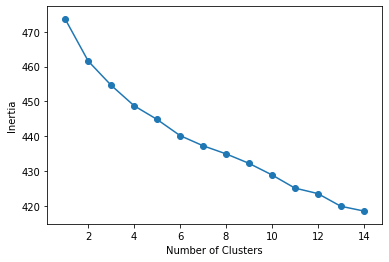

In [177]:
inertia = []
list_num_clusters = list(range(1,15))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(df1)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [178]:
num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(df1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [179]:
km.cluster_centers_

array([[ 1.92438523e-01, -8.30861366e-02, -5.46191913e-02, ...,
         2.96064847e-06,  2.24913203e-03, -2.31686774e-03],
       [ 2.47332506e-01, -1.56129810e-01,  2.10401037e-01, ...,
        -2.50977772e-03, -1.18733252e-03,  8.67357620e-04],
       [ 2.26706776e-01, -9.74252467e-02, -2.31715550e-02, ...,
         1.31673045e-03,  2.07466891e-04, -3.60246999e-04],
       [ 3.40445181e-01,  3.13202713e-01,  8.19268466e-02, ...,
        -1.44190078e-03,  1.16231632e-03,  5.83175315e-04],
       [ 1.87069500e-01, -6.85495198e-02,  5.11450428e-02, ...,
         1.86023964e-03, -8.10756108e-04,  2.23626480e-04],
       [ 2.87320610e-01,  1.73552130e-02, -1.06395037e-01, ...,
        -5.93788685e-04,  7.30139117e-04,  2.48574728e-04]])

# Chronologial news recommender

In [291]:
# examine the topics in each news article, fill in document id to retrive the news

# start with this article

document_id = 77928
# df.index[db.core_sample_indices_[0]]
# 47865
# 101140
# 169593 #stonewall inn
# 74374
# 55529
# 54962
# 77928
# 55502
df_doc_top = df1.sub(df1.mean(axis=1), axis=0)

lst = [] 

# for i, j in enumerate(cosine_similarity( km.cluster_centers_[0].reshape(1, -1), df_doc_top)[0]):
for i, j in enumerate(cosine_similarity(np.array(df_doc_top[df_doc_top.index == document_id]).reshape(1, -1), df_doc_top)[0]):
    lst.append([round(j, 2), df_doc_top.index[i],  df.loc[df.index ==  df_doc_top.index[i], "date"].values[0] ])

relavent_sort = sorted(lst, reverse=True)[0:35]
    
recommend_id = sorted( relavent_sort, key = lambda x: x[2])

print("recommended news are: {}".format(recommend_id) , end="\n \n")

for i in recommend_id:
    
    statement = re.sub(r"[^a-zA-Z]"," ", df[df.id == i[1]].content.values[0])
    sentiment = TextBlob(statement)
    sentiment_score = sentiment.sentiment.polarity
    
    print("date:", i[2], "cosine similarity:",  i[0], df.loc[df.index==i[1], "publication"].values[0], \
      "id =", i[1], "sentiment score: {:0.3f}".format(sentiment_score), "\nTitle: ", df.loc[df.index==i[1], "title"].values[0],  
      "\n \n", df[df.id == i[1]].content.values[0][:275], "...", end="\n \n \n")


# document_id = recommend_id[random.randint(1, 8)][1]

recommended news are: [[0.82, 169896, '2016-06-12'], [0.82, 108538, '2016-06-12'], [0.81, 77901, '2016-06-12'], [0.59, 34972, '2016-06-12'], [0.49, 170047, '2016-06-12'], [0.45, 142097, '2016-06-12'], [0.4, 38704, '2016-06-12'], [0.39, 77902, '2016-06-12'], [0.37, 212716, '2016-06-12'], [0.34, 119580, '2016-06-12'], [0.68, 41403, '2016-06-13'], [0.55, 44572, '2016-06-13'], [0.54, 47456, '2016-06-13'], [0.45, 212734, '2016-06-13'], [0.45, 77927, '2016-06-13'], [0.39, 77924, '2016-06-13'], [0.34, 212871, '2016-06-13'], [1.0, 77928, '2016-06-14'], [0.66, 43263, '2016-06-14'], [0.51, 47685, '2016-06-14'], [0.43, 108630, '2016-06-14'], [0.4, 108589, '2016-06-14'], [0.34, 119604, '2016-06-14'], [0.34, 77951, '2016-06-14'], [0.69, 47165, '2016-06-15'], [0.36, 84778, '2016-06-18'], [0.38, 37120, '2016-06-19'], [0.73, 212919, '2016-06-20'], [0.36, 55380, '2016-06-21'], [0.34, 189711, '2016-06-26'], [0.34, 55518, '2016-06-26'], [0.33, 151536, '2016-06-26'], [0.35, 40763, '2016-07-03'], [0.33, 10

date: 2016-06-14 cosine similarity: 0.66 Breitbart id = 43263 sentiment score: 0.060 
Title:  **Live Wire** Jihad in Orlando: How Can We Prevent Another Pulse Massacre? - Breitbart 
 
 Breitbart News presents live coverage of the aftermath of the jihadist Omar Mateen’s massacre at Orlando’s Pulse night club. Two days after the largest terrorist attack on U.S. soil since 9/11, debates rage over immigration from Islamic-majority nations and expanded gun cont ...
 
 
date: 2016-06-14 cosine similarity: 0.51 Breitbart id = 47685 sentiment score: 0.182 
Title:  Gay Dating App Jack'd Says No Record of Orlando Jihadi Account 
 
 After a slew of reports that Omar Mateen was himself gay, the FBI “told members of the LGBT community it will pursue accounts that the Orlando nightclub shooter was partially motivated by internal conflict over his own sexuality,” according to the UK Guardian.[“FBI officials ...
 
 
date: 2016-06-14 cosine similarity: 0.43 Buzzfeed News id = 108630 sentiment score: 0.